### 受力变形正向计算

对于稳态固体弹性变形，研究具有角方向对称性的密封环，使用PINN方法，并将结果与有限元进行对比

In [1]:
from math import pi as PI
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import os
import ast

from PINN.diff import diff
from PINN.networks import FCNN
from PINN.conditions import BoundaryCondition
from PINN.generators import generator_2dspatial_rectangle, generator_2dspatial_segment
from PINN.solvers import SingleNetworkApproximator2DSpatial
from PINN.monitors import Monitor2DSpatial
from PINN.solvers import _solve_2dspatial


In [2]:
r1=0.135 #内径
r2=0.1695  #外径
h1=0.02  #高

E= 420*10**9 #杨氏模量
mu =0.14 #泊松比
G=E/2/(1+mu)  #剪切模量
alpha=4*10**-6 #线膨胀系数
beta=alpha *E /(1-2*mu) #热应力系数

parser = argparse.ArgumentParser(description='PyTorch Deep Learning Training Force Forward')

# 添加命令行参数
parser.add_argument('--lr', type=float, default=0.00003, help='学习率')
parser.add_argument('--batch_size', type=int, default=2500, help='批量大小')
parser.add_argument('--epochs', type=int, default=1000000, help='训练轮数')
parser.add_argument('--gpu', type=bool , default=False ,help='使用GPU进行训练')
parser.add_argument('--train_rec_size', type=int , default=100 ,help='矩形区域内生成的点,512*512')
parser.add_argument('--train_bound_size', type=int , default=64 ,help='边界上生成的点数')
parser.add_argument('--train_gen_random', type=bool , default=True ,help='训练生成点是否随机')
parser.add_argument('--valid_gen_random', type=bool , default=True ,help='验证生成点是否随机')
parser.add_argument('--weight_up', type=int , default=3 ,help='上边界权重')
parser.add_argument('--weight_left', type=int , default=2 ,help='左边界权重')
parser.add_argument('--weight_right', type=int , default=5 ,help='右边界权重')
parser.add_argument('--weight_bottom', type=int , default=2 ,help='下边界权重')
parser.add_argument('--weight_equ2', type=int , default=1 ,help='控制方程2权重')
parser.add_argument('--boundary_strictness', type=int , default=1 ,help='边界严格参数')
parser.add_argument('--network_MLP', type=str , default="32,32,32,32,32" ,help='全连接网络形状')
parser.add_argument('--check_every', type=int , default=1 ,help='检测周期')
parser.add_argument('--save_dict', type=str , default='run1' ,help='训练文件名')
parser.add_argument('--maxf', type=int , default=10 ,help='端面相对温度最大值')
parser.add_argument('--impose', type=int , default=1 ,help='是否强加Drichlet边界,1为施加')
parser.add_argument('--mtl', type=int , default=0 ,help='是否使用多任务权重学习,1为使用')
parser.add_argument('--disp_accumulate', type=int , default=1 ,help='位移累积层')



args = parser.parse_args(args=[])
print(args)

save_folder = args.save_dict + "-image/"

# 确保文件夹存在，如果不存在则创建
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

use_gpu = args.gpu
device = torch.device("mps" if use_gpu else "cpu")
if use_gpu:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}

Namespace(lr=3e-05, batch_size=1024, epochs=1000000, gpu=False, train_rec_size=64, train_bound_size=64, train_gen_random=True, valid_gen_random=True, weight_up=3, weight_left=2, weight_right=5, weight_bottom=2, weight_equ2=1, boundary_strictness=1, network_MLP='32,32,32,32,32', check_every=200, save_dict='run1', maxf=10, impose=1, mtl=0, disp_accumulate=1)


In [3]:
def calculate_sigma_rr(u,w,r,z):
    return 2*G * ((1-mu)/(1-2*mu)*diff(u,r)/(r2-r1) + mu/(1-2*mu)*(u/((r2-r1)*r+r1)+diff(w,z)/h1)) *10**-12

def calculate_sigma_theta(u,w,r,z):
    return 2*G * ((1-mu)/(1-2*mu)*u/((r2-r1)*r+r1) + mu/(1-2*mu)*(diff(w,z)/h1+diff(u,r)/(r2-r1)))*10**-12

def calculate_sigma_zz(u,w,r,z):
    return 2*G * ((1-mu)/(1-2*mu)*diff(w,z)/h1 + mu/(1-2*mu)*(u/((r2-r1)*r+r1)+diff(u,r)/(r2-r1)))*10**-12

def calculate_tau_zr(u,w,r,z):
    return G*(diff(w,r)/(r2-r1)+diff(u,z)/h1)*10**-12  ##MPa  um

def force_balance_r(u,w,r,z):
    sigma_rr=calculate_sigma_rr(u,w,r,z)
    sigma_theta=calculate_sigma_theta(u,w,r,z)
    sigma_zz=calculate_sigma_zz(u,w,r,z)
    tau_zr=calculate_tau_zr(u,w,r,z)

    return diff(sigma_rr,r)/(r2-r1)+diff(tau_zr,z)/h1+(sigma_rr-sigma_theta)/((r2-r1)*r+r1)

def force_balance_z(u,w,r,z):
    sigma_rr=calculate_sigma_rr(u,w,r,z)
    sigma_theta=calculate_sigma_theta(u,w,r,z)
    sigma_zz=calculate_sigma_zz(u,w,r,z)
    tau_zr=calculate_tau_zr(u,w,r,z)

    return diff(sigma_zz,z)/h1+diff(tau_zr,r)/(r2-r1)+tau_zr/((r2-r1)*r+r1)


In [4]:
p_left=-10 #MPa
p_right=-1 #MPa

#left
boundary_left=BoundaryCondition(
    form=lambda u,x,y: calculate_sigma_rr(u[:,0],u[:,1],x,y)-p_left,
    points_generator=generator_2dspatial_segment(size=args.train_bound_size, start=(0.0, 0.0), end=(0.0, 1.0),device=device),
    weight=args.weight_left,
    impose=0,
)

#bottom
boundary_bottom=BoundaryCondition(
    form=lambda u,x,y: u[:,1],
    points_generator=generator_2dspatial_segment(size=args.train_bound_size, start=(0.0, 0.0), end=(1.0, 0.0),device=device),
    weight=args.weight_bottom,
    impose=1,
)

#right
boundary_right=BoundaryCondition(
    form=lambda u,x,y: calculate_sigma_rr(u[:,0],u[:,1],x,y)-p_right,
    points_generator=generator_2dspatial_segment(size=args.train_bound_size, start=(1.0, 0.0), end=(1.0, 1.0),device=device),
    weight=args.weight_right,
    impose=0,
)

#up
boundary_up=BoundaryCondition(
    form=lambda u,x,y: calculate_sigma_zz(u[:,0],u[:,1],x,y)-((p_left-p_right)*(2*x*x*x-3*x*x+1)+p_right),
    points_generator=generator_2dspatial_segment(size=args.train_bound_size, start=(0.0, 1.0), end=(1.0, 1.0),device=device),
    weight=args.weight_up,
    impose=0,
)


#观测各边界以及方程的损失
metrics={}
#方程
def equ1(uu,xx,yy):
    error=force_balance_r(uu[:,0],uu[:,1],xx,yy)
    return torch.mean(abs(error)**2)
metrics['equ1']=equ1

def equ2(uu,xx,yy):
    error=force_balance_z(uu[:,0],uu[:,1],xx,yy)
    return torch.mean(abs(error)**2)
metrics['equ2']=equ2

#左边界
def leftbound_mse(uu,xx,yy):
    x,y=next(boundary_left.points_generator)
    u=fcnn_approximator.__call__(x.requires_grad_(),y.requires_grad_())
    error=boundary_left.form(u,x,y)
    return torch.mean(abs(error)**2)
metrics['leftbound_mse']=leftbound_mse

#下边界
def bottombound_mse(uu,xx,yy):
    x,y=next(boundary_bottom.points_generator)
    u=fcnn_approximator.__call__(x.requires_grad_(),y.requires_grad_())
    error=boundary_bottom.form(u,x,y)
    return torch.mean(abs(error)**2)
metrics['bottombound_mse']=bottombound_mse

#右边界
def rightbound_mse(uu,xx,yy):
    x,y=next(boundary_right.points_generator)
    u=fcnn_approximator.__call__(x.requires_grad_(),y.requires_grad_())
    error=boundary_right.form(u,x,y)
    return torch.mean(abs(error)**2)
metrics['rightbound_mse']=rightbound_mse

#上边界
def upbound_mse(uu,xx,yy):
    x,y=next(boundary_up.points_generator)
    u=fcnn_approximator.__call__(x.requires_grad_(),y.requires_grad_())
    error=boundary_up.form(u,x,y)
    return torch.mean(abs(error)**2)
metrics['upbound_mse']=upbound_mse

fcnn = FCNN(
    n_input_units=2,
    n_output_units=2,
    hidden_units=ast.literal_eval(args.network_MLP),
    actv=nn.Tanh
)

fcnn=fcnn.to(device)

fcnn_approximator = SingleNetworkApproximator2DSpatial(
    single_network=fcnn,
    #single_network=renn,
    pde=(force_balance_r,force_balance_z),
    boundary_conditions=[
        boundary_left,
        boundary_bottom,
        boundary_right,
        boundary_up
    ],
    boundary_strictness=args.boundary_strictness,
    args=args
)
size_train=args.train_rec_size
adam=optim.Adam(fcnn_approximator.parameters(),lr=args.lr)
train_gen_spatial = generator_2dspatial_rectangle(size=(size_train, size_train), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0,device=device,random=args.train_gen_random)
valid_gen_spatial = generator_2dspatial_rectangle(size=(50, 50), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, random=args.valid_gen_random,device=device)

/Users/yst/Documents/本科项目/毕设/PINN-Thermoelastic-F-I/force_forward/PINN/monitors.py:78: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[i,j].set_yscale('log')


KeyboardInterrupt: 

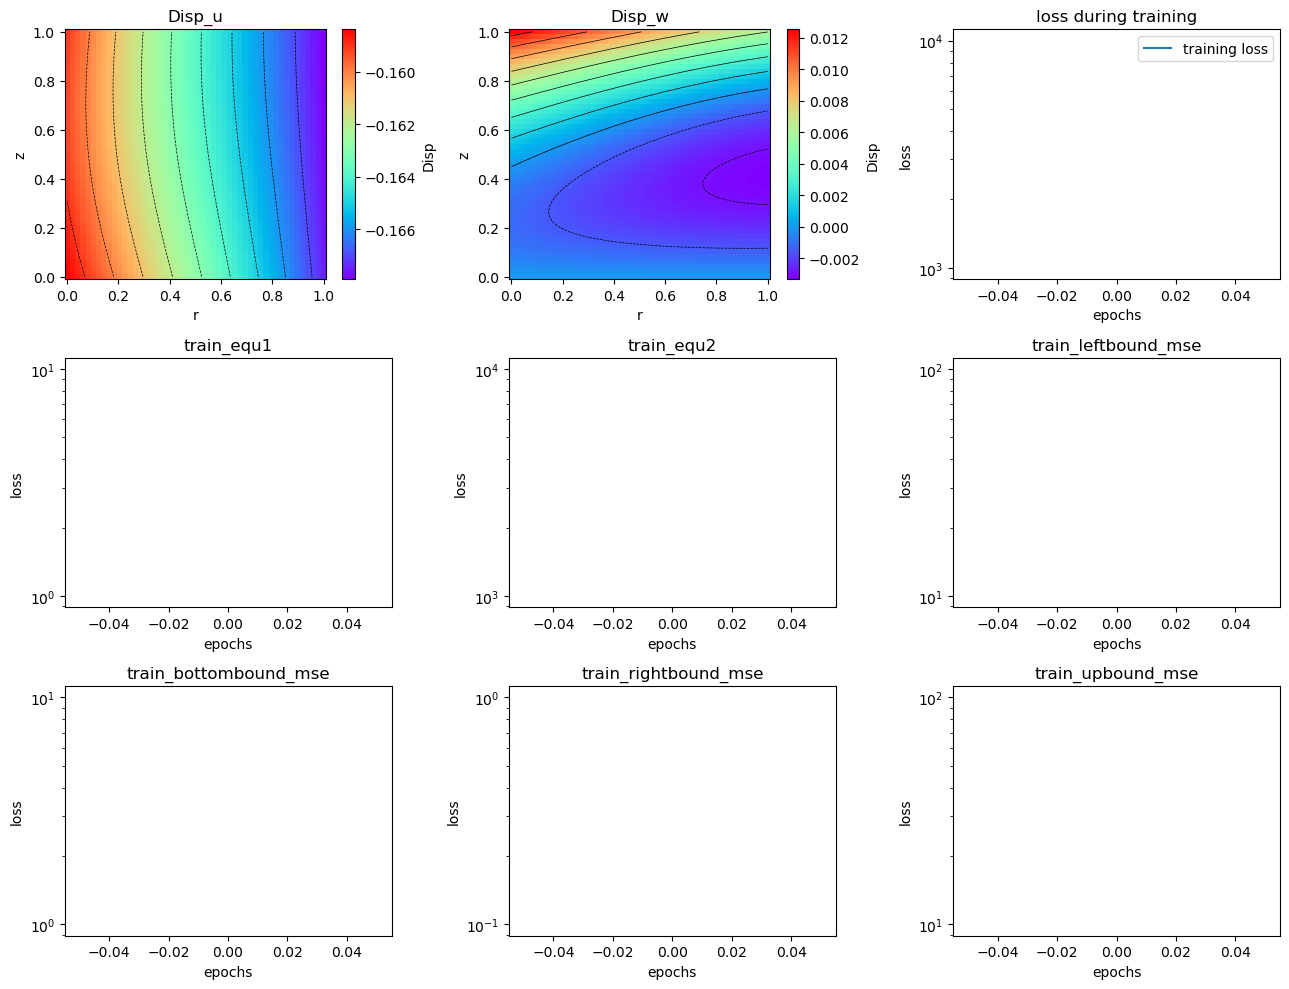

In [5]:
#%matplotlib inline
heat_transfer_2d_solution, _ = _solve_2dspatial(
    train_generator_spatial=train_gen_spatial,
    valid_generator_spatial=valid_gen_spatial,
    approximator=fcnn_approximator,
    optimizer=adam,
    batch_size=args.batch_size,
    max_epochs=args.epochs,
    shuffle=True,
    metrics=metrics,
    monitor=Monitor2DSpatial(        
        check_on_x=torch.linspace(0.0, 1.0, 50),
        check_on_y=torch.linspace(0.0, 1.0, 50),
        check_every=args.check_every,
        device=device,
        args=args
    ),
    device=device,
    args=args
)

In [10]:
xx=torch.linspace(0.0, 1.0, 50)
yy=torch.linspace(0.0, 1.0, 50)
xy_tensor = torch.cartesian_prod(xx,yy).to(device)
xx_tensor = torch.squeeze(xy_tensor[:, 0]).requires_grad_()
yy_tensor = torch.squeeze(xy_tensor[:, 1]).requires_grad_()
uu=fcnn_approximator.__call__(xx_tensor,yy_tensor)
sigma_rr=calculate_sigma_rr(uu[:,0],uu[:,1],xx_tensor,yy_tensor)
sigma_zz=calculate_sigma_zz(uu[:,0],uu[:,1],xx_tensor,yy_tensor)
sigma_phi=calculate_sigma_theta(uu[:,0],uu[:,1],xx_tensor,yy_tensor)
sigma_zr=calculate_tau_zr(uu[:,0],uu[:,1],xx_tensor,yy_tensor)

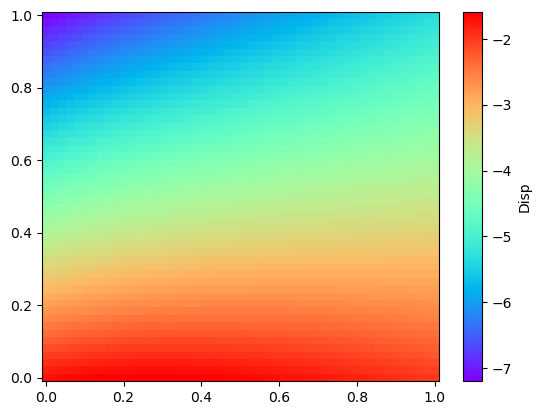

In [30]:
x, y = np.meshgrid(xx, yy)
sigma_zr=sigma_zr.detach().cpu().numpy()
# 创建热力图
heatmap=plt.pcolormesh(x, y, sigma_zr.reshape(x.shape).T,cmap='rainbow')  # cmap是颜色映射，你可以根据需要选择
cbar=plt.colorbar(heatmap,label='Disp')
plt.show()

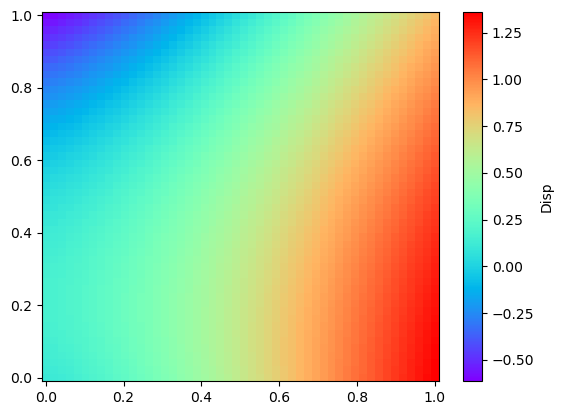

In [28]:
x, y = np.meshgrid(xx, yy)
sigma_phi=sigma_phi.detach().cpu().numpy()
# 创建热力图
heatmap=plt.pcolormesh(x, y, sigma_phi.reshape(x.shape).T,cmap='rainbow')  # cmap是颜色映射，你可以根据需要选择
cbar=plt.colorbar(heatmap,label='Disp')
plt.show()

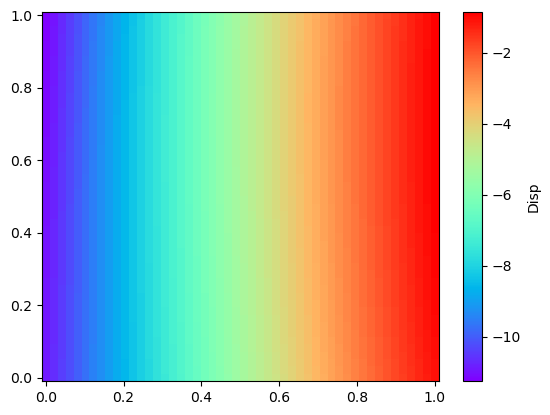

In [25]:
x, y = np.meshgrid(xx, yy)
sigma_zz=sigma_zz.detach().cpu().numpy()
# 创建热力图
heatmap=plt.pcolormesh(x, y, sigma_zz.reshape(x.shape).T,cmap='rainbow')  # cmap是颜色映射，你可以根据需要选择
cbar=plt.colorbar(heatmap,label='Disp')
plt.show()

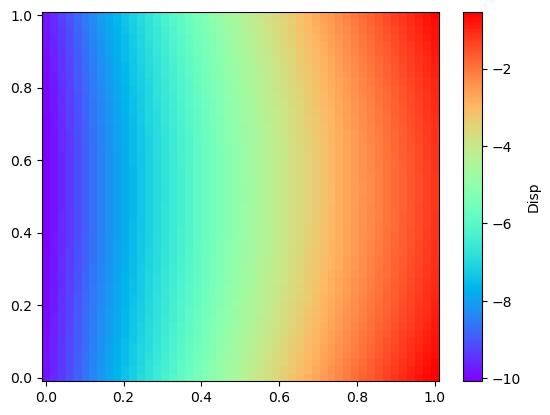

In [23]:
x, y = np.meshgrid(xx, yy)
sigma_rr=sigma_rr.detach().cpu().numpy()
# 创建热力图
heatmap=plt.pcolormesh(x, y, sigma_rr.reshape(x.shape).T,cmap='rainbow')  # cmap是颜色映射，你可以根据需要选择
cbar=plt.colorbar(heatmap,label='Disp')
plt.show()

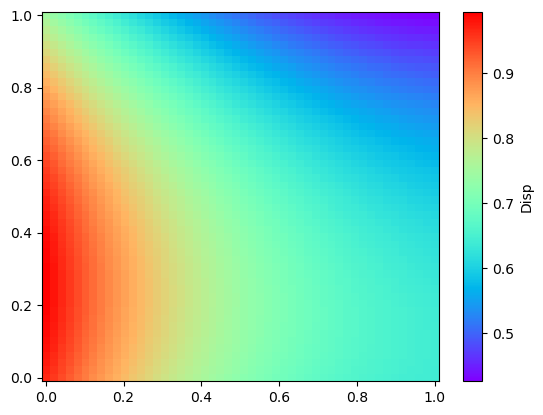

In [15]:
x, y = np.meshgrid(xx, yy)
uu=uu.detach().cpu().numpy()
# 创建热力图
heatmap=plt.pcolormesh(x, y, uu[:,0].reshape(x.shape).T,cmap='rainbow')  # cmap是颜色映射，你可以根据需要选择
cbar=plt.colorbar(heatmap,label='Disp')
plt.show()

In [26]:
import math

m=int(math.sqrt(uu.shape[0]))
delta_r=(r2-r1)/m
delta_z=h1/m
uu_clone=uu
ut_mat = torch.zeros_like(uu[:,0].reshape(m,m))
for i in range(m):
    for j in range(i, m):
        ut_mat[i, j] = 1
result=torch.mm(uu_clone[:,0].reshape(m,m),delta_r*ut_mat)
print(result)
print(uu_clone[:,0].reshape(m,m))

tensor([[6.9819e-06, 1.4115e-05, 2.1395e-05,  ..., 4.4907e-04, 4.5980e-04,
         4.7055e-04],
        [7.0069e-06, 1.4162e-05, 2.1463e-05,  ..., 4.4809e-04, 4.5876e-04,
         4.6946e-04],
        [7.0313e-06, 1.4209e-05, 2.1529e-05,  ..., 4.4706e-04, 4.5768e-04,
         4.6832e-04],
        ...,
        [6.9128e-06, 1.3862e-05, 2.0846e-05,  ..., 3.5063e-04, 3.5803e-04,
         3.6543e-04],
        [6.8751e-06, 1.3785e-05, 2.0727e-05,  ..., 3.4742e-04, 3.5475e-04,
         3.6207e-04],
        [6.8357e-06, 1.3704e-05, 2.0603e-05,  ..., 3.4418e-04, 3.5142e-04,
         3.5866e-04]], grad_fn=<MmBackward0>)
tensor([[0.0101, 0.0103, 0.0106,  ..., 0.0155, 0.0155, 0.0156],
        [0.0102, 0.0104, 0.0106,  ..., 0.0154, 0.0155, 0.0155],
        [0.0102, 0.0104, 0.0106,  ..., 0.0154, 0.0154, 0.0154],
        ...,
        [0.0100, 0.0101, 0.0101,  ..., 0.0107, 0.0107, 0.0107],
        [0.0100, 0.0100, 0.0101,  ..., 0.0106, 0.0106, 0.0106],
        [0.0099, 0.0100, 0.0100,  ..., 0.0105, 0